In [1]:
import numpy as np
import pandas as pd
from lstm_functions import *
from lost_functions import *
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
from backtest import backtest_model

# <a id='toc1_'></a>[This to try to tune and try to get a good prediction for Apple Stock](#toc0_)
If i can get a good prediction for Apple Stock, then i can use the same model for other stocks  
This notebook is mainly to tune the model and get a good prediction for Apple Stock

# <a id='toc2_'></a>[Reading and storing the Data](#toc0_)

In [4]:
xls = pd.ExcelFile('data/data_for_testing.xlsx')
all_data = {}
# This is too much data to load into memory at once
# for sheet in xls.sheet_names:
#     all_data[sheet] = pd.read_excel(xls, sheet_name=sheet)
for sheet in ["AAPL"]:
    data = pd.read_excel(xls, sheet_name=sheet).set_index('Date')
    # Resample to monthly data as a simple way to reduce the number of data points
    # Daily data is too much and take too long to train
    new_data = data.resample('M').last().reset_index()
    new_data = new_data[new_data['Date'] < '2019-12-01']
    all_data[sheet] = new_data

In [5]:
all_data["AAPL"].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sector',
       'Ticker'],
      dtype='object')

<AxesSubplot:>

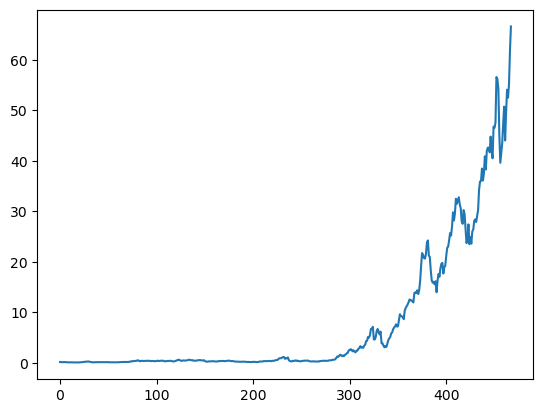

In [6]:
all_data["AAPL"]["Open"].plot()

In [7]:
final_importance_values = {}
final_predictions = {}
# 30 is not a good number of batches, but it's a start for testing
# 60 is a good number of batches, but it takes a long time to train
time_steps = 12
features = 6

In [8]:
def evaluate_model(y_train, train_predictions, y_test, test_predictions, ticker, feature):
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)

    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

    print(f"\nEvaluation for {ticker} on {feature}:")
    print(f"Training MAE: {train_mae}, Testing MAE: {test_mae}")
    print(f"Training RMSE: {train_rmse}, Testing RMSE: {test_rmse}\n")
    return train_mae, test_mae, train_rmse, test_rmse


In [9]:
def plot_predictions(y_train, train_predictions, y_test, test_predictions, ticker, feature):
    plt.figure(figsize=(14,7))
    plt.plot(y_train, label="Actual Train Values", color='blue')
    plt.plot(train_predictions, label="Predicted Train Values", color='blue', linestyle='dashed')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label="Actual Test Values", color='red')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predictions, label="Predicted Test Values", color='red', linestyle='dashed')
    plt.title(f"{ticker} {feature} - Actual vs Predicted Values")
    plt.legend()
    plt.show()


In [14]:
def information_coefficient_loss(y_true, y_pred):
    """
    Calculate the Information Coefficient (IC) between y_true and y_pred.

    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.

    Returns:
        float: 1/Information Coefficient.
    """
    cov_matrix = np.cov(y_true, y_pred)
    ic = cov_matrix[0, 1] / np.sqrt(cov_matrix[0, 0] * cov_matrix[1, 1])
    return 1/ic

# <a id='toc1_'></a>[Backtesting model predictions from different loss functions](#toc0_)


In [18]:
ticker = "AAPL"
data = all_data[ticker]
data = data.drop(columns=['Sector', 'Ticker', 'Date'])  # Assuming 'Date' is the index
best_fn, mse = None, float('inf')
# print(final_predictions[ticker])
loss_fns = [huber_loss, mean_squared_error, mean_absolute_error, rmse, mape, information_coefficient_loss]
for loss_fn in loss_fns:
    lstm_model = LstmBuilder(time_step=time_steps, loss=loss_fn)
    model = lstm_model.create_model(features=features)
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    X, y = lstm_model.create_sequences(normalized_data)
    X_train, X_test, y_train, y_test = lstm_model.split_data(X,y, size=0.95)
    print(len(X_train), len(X_test))
    print(len(y_train), len(y_test))

    print("Working on: " + ticker)  
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

    # Predict the next day value
    last_days = normalized_data[-time_steps:].reshape(1, time_steps, features)
    prediction_next_day = model.predict(last_days)
    prediction_next_day_actual = scaler.inverse_transform(prediction_next_day)
    final_predictions[ticker] = prediction_next_day_actual.flatten()
    backtested_mse = backtest_model()
    
    
    

433 23
433 23
Working on: AAPL
[[[0.59428966 0.59427881 0.58813925 0.58988449 0.58121353 0.01741544]
  [0.62274608 0.63027984 0.61855266 0.62246603 0.61330711 0.02051157]
  [0.65356762 0.65235103 0.65002    0.64759498 0.64079916 0.01375149]
  [0.71179437 0.7090041  0.70881422 0.71051108 0.70303885 0.01124085]
  [0.76146167 0.75874824 0.7486001  0.75065754 0.74275362 0.02363964]
  [0.66073799 0.66385344 0.65781158 0.65478544 0.65041003 0.013119  ]
  [0.74501851 0.74418353 0.7408462  0.74035878 0.73538937 0.01531421]
  [0.81161704 0.82585805 0.7944837  0.79698324 0.79162091 0.03591732]
  [0.78811612 0.7850768  0.77905113 0.78087976 0.7785787  0.0099343 ]
  [0.82843559 0.83784597 0.83020436 0.83791618 0.83543428 0.01254351]
  [0.92731977 0.92967847 0.89219803 0.93075483 0.92797876 0.01730047]
  [1.         1.         1.         1.         1.         0.00481251]]]
1/1 [==============================] - 0s 80ms/step


433 23
433 23
Working on: AAPL
1/1 [==============================] - 0s 93ms/step
Predicted value for AAPL: [6.3111637e+01 2.3718985e+01 6.7540276e+01 4.3732647e+01 7.7223030e+01
 3.6495416e+09]
Importance value for AAPL: -1.2366595268249512
1/1 [==============================] - 0s 11ms/step

Evaluation for AAPL on Open:
Training MAE: 0.7784171137202199, Testing MAE: 4.923664258873981
Training RMSE: 1.652670048890306, Testing RMSE: 5.854669099572176



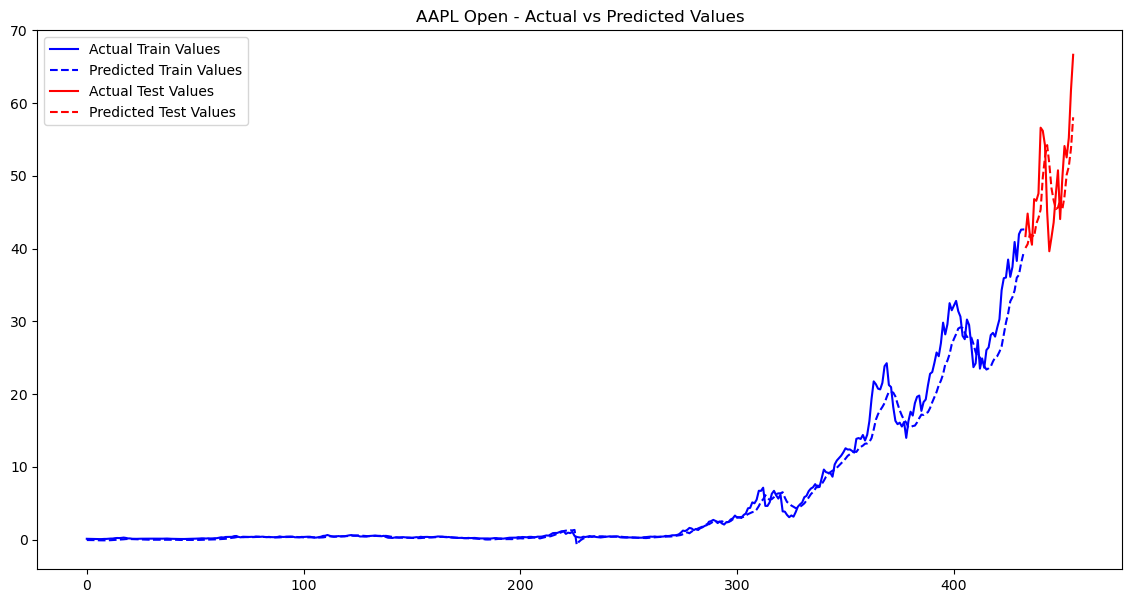


Evaluation for AAPL on High:
Training MAE: 1.5904896286906762, Testing MAE: 26.759680126024328
Training RMSE: 3.8553450407133343, Testing RMSE: 27.756260839836408



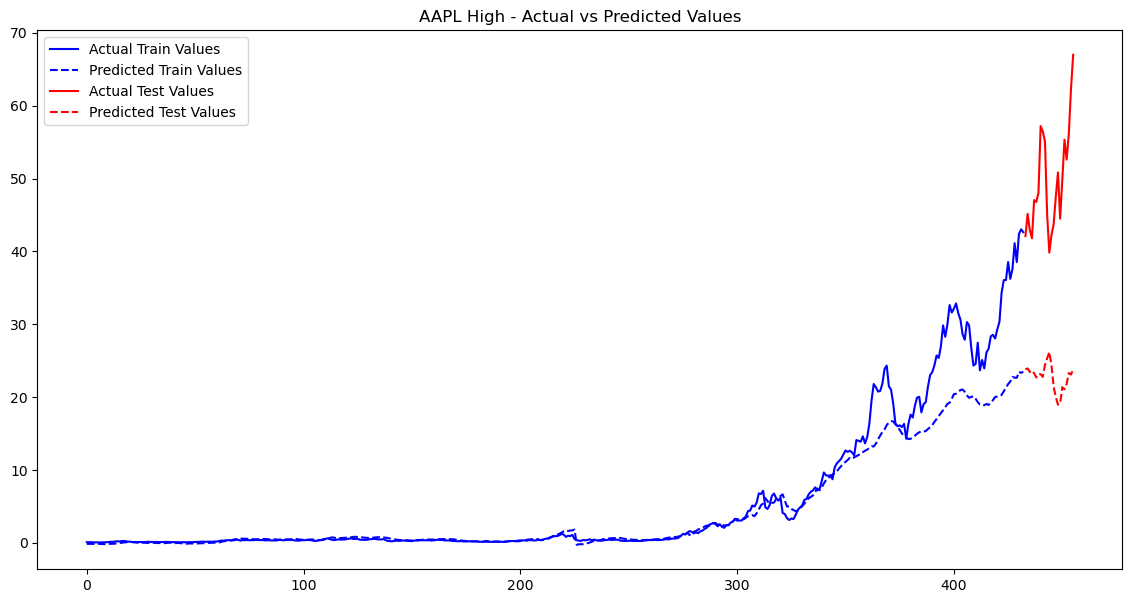


Evaluation for AAPL on Low:
Training MAE: 0.4710371391353033, Testing MAE: 4.244937896728515
Training RMSE: 0.9957755890974912, Testing RMSE: 5.99263559208994



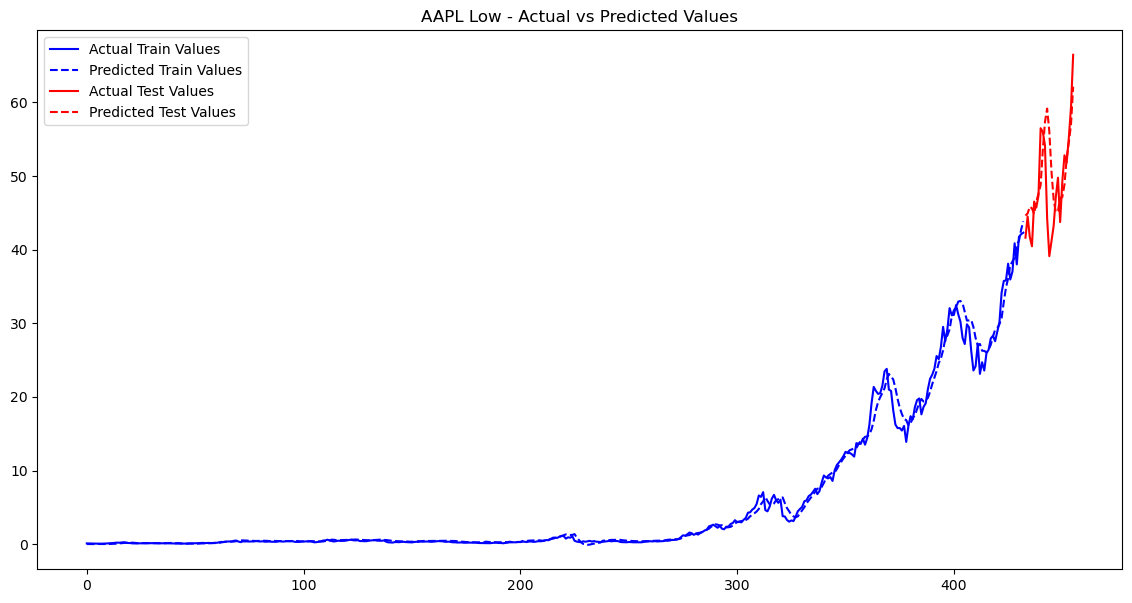


Evaluation for AAPL on Close:
Training MAE: 0.9723074100873977, Testing MAE: 14.916662382042926
Training RMSE: 2.204512468671547, Testing RMSE: 16.226429978809037



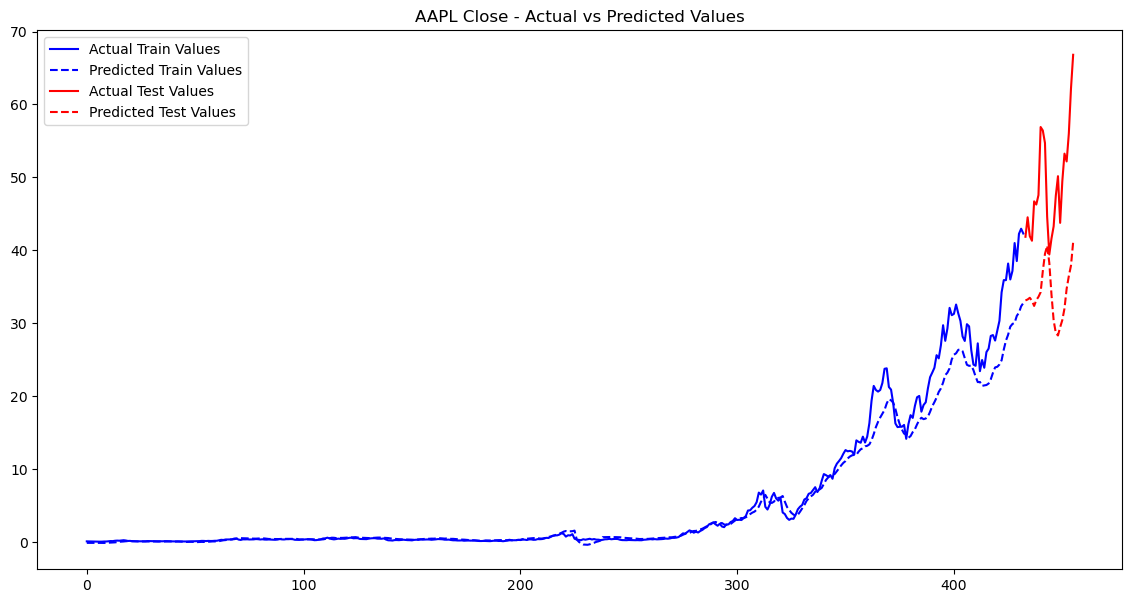


Evaluation for AAPL on Adj Close:
Training MAE: 0.551637082417145, Testing MAE: 4.841447249702784
Training RMSE: 1.1055278644008737, Testing RMSE: 6.797180327618174



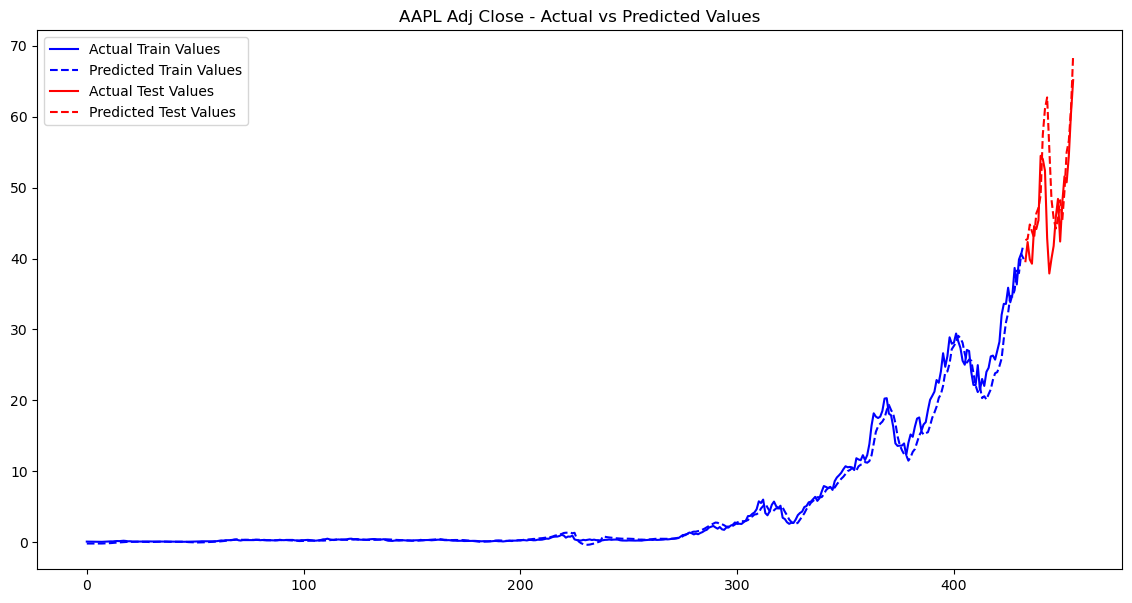


Evaluation for AAPL on Volume:
Training MAE: 391434712.18475753, Testing MAE: 2559480777.7391305
Training RMSE: 750996877.1997042, Testing RMSE: 2590075215.8794074



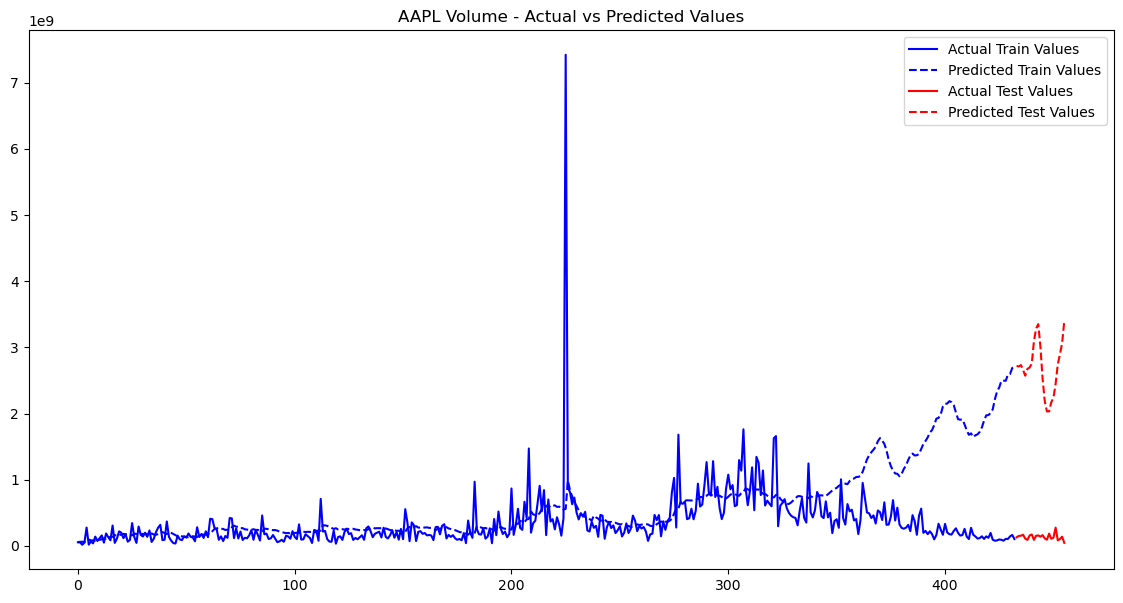

In [11]:
ticker = "AAPL"
data = all_data[ticker]

# Drop non-numeric columns
data = data.drop(columns=['Sector', 'Ticker', 'Date'])  # Assuming 'Date' is the index
lstm_model = LstmBuilder(time_step=time_steps, loss=huber_loss)
model = lstm_model.create_model(features=features)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)
X, y = lstm_model.create_sequences(normalized_data)
X_train, X_test, y_train, y_test = lstm_model.split_data(X,y, size=0.95)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

print("Working on: " + ticker)  
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

# Predict the next day value
last_days = normalized_data[-time_steps:].reshape(1, time_steps, features)
prediction_next_day = model.predict(last_days)
prediction_next_day_actual = scaler.inverse_transform(prediction_next_day)
final_predictions[ticker] = prediction_next_day_actual.flatten()
print(f"Predicted value for {ticker}: {prediction_next_day_actual.flatten()}")


# Extracting importance
dense_weights = model.layers[-1].get_weights()[0]

# Think about to use sum or mean and to use abs() or not
feature_weights = dense_weights.sum(axis=0)
weighted_importance = prediction_next_day.flatten() * feature_weights
final_importance_value = np.sum(weighted_importance)  # Final importance as a single value
print(f"Importance value for {ticker}: {final_importance_value}")

# Store the importance value in the dictionary
final_importance_values[ticker] = final_importance_value

# Predict for both training and testing data
train_predictions = scaler.inverse_transform(model.predict(X_train))
test_predictions = scaler.inverse_transform(model.predict(X_test))
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
features_list = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for feature_index, feature_name in enumerate(features_list):
    # Extracting data for the specific feature
    y_train_feature = y_train[:, feature_index]
    y_test_feature = y_test[:, feature_index]
    train_predictions_feature = train_predictions[:, feature_index]
    test_predictions_feature = test_predictions[:, feature_index]

    # Evaluating the model for this feature
    evaluate_model(y_train_feature, train_predictions_feature, y_test_feature, test_predictions_feature, ticker, feature_name)

    # Plotting the results for this feature
    plot_predictions(y_train_feature, train_predictions_feature, y_test_feature, test_predictions_feature, ticker, feature_name)


In [12]:
final_importance_values

{'AAPL': -1.2366595}